# ECE113 Lab 2 Part II - Broadcast FM

Originally written by Miki Lustig. Updated by Josh Sanz in Spring 2020.
Updated for UCLA ECE113, Spring 2021.

If you have problems importing rtlsdr, please shut down jupyter notebook, open anaconda prompt, run 'pip install pyrtlsdr', open jupyter notebook and try to import it one more time

In [1]:
import numpy as np, matplotlib.pyplot as plt
import matplotlib
from numpy import *
from numpy.fft import *
import scipy.signal as signal
from matplotlib.pyplot import *
from rtlsdr import RtlSdr
import scipy
import scipy.io
from scipy.io.wavfile import write
import sounddevice as sd
import gc
%matplotlib inline


Below are some functions from Part I that we will need in this part

In [25]:
# Plot an image of the spectrogram y, with the axis labeled with time tl,
# and frequency fl
#
# t_range -- time axis label, nt samples
# f_range -- frequency axis label, nf samples
# y -- spectrogram, nf by nt array
# dbf -- Dynamic range of the spectrum

def sg_plot( t_range, f_range, y, dbf = 40, fig = None) :
    
    eps = 10.0**(-dbf/20.0)  # minimum signal
    
    # find maximum
    y_max = abs(y).max()
    
    # compute 20*log magnitude, scaled to the max
    y_log = 20.0 * np.log10( (abs( y ) / y_max)*(1-eps) + eps )
    
    # rescale image intensity to 256
    img = 256*(y_log + dbf)/dbf - 1
    
 
    fig=figure(figsize=(8,4))
    
    plt.imshow( np.flipud( 64.0*(y_log + dbf)/dbf ), extent= t_range  + f_range ,cmap=plt.cm.gray, aspect='auto')
    plt.xlabel('Time, s')
    plt.ylabel('Frequency, Hz')
    plt.tight_layout()
    
    return fig
    
    

## Part II: Broadcast FM Radio


### Task 5: Time-Frequency plots of the radio-frequency spectrum with the SDR.

The samples that are obtained by the SDR represent a bandwidth of the spectrum around a center frequency. Hence, when demodulating to base-band (i.e. zero frequency) the signal must be complex-valued since it has a non symmetric Fourier transform. 

In this case, we would like to display both sides of the spectrum.

- Modify the function `myspectrogram_hann_ovlp(x,m,fs,fc)` such that it detects whether the input signal `x` is complex. In that case, it will compute a double sided spectrum with frequency range centered around fc (center frequency). For this, it would be useful to use the commands: `isreal` and `fftshift`.


### Solution:

In [26]:
def myspectrogram_hann_ovlp(x, m, fs, fc, dbf = 40, fig = None):
    # Plot the spectrogram of x.
    # First take the original signal x and split it into blocks of length m
    
    
    lx = len(x);
    nt = (lx + m - 1) // m # // enforces integer division
    xp = append(x,zeros(-lx+nt*m))
    xp = np.reshape(xp,(m//2,nt*2),order = 'F')
    xp = concatenate((xp,xp),axis=0)
    xp = np.reshape(xp,(m*nt*2,1),order = 'F')
    xp = xp[r_[m//2:len(xp),ones(m//2)*(len(x)-1)].astype(int)].reshape((m,nt*2),order='F')
    xmw = xp * hanning(m)[:,None] 
    xmf = fft(xmw,len(xmw),axis = 0) 
    
    t_range = [0 , lx / fs]
    if not all(isreal(xmf)): #making change to the range when the signal is not real
        xmf = fftshift(xmf)
        f_range = [fc-fs/2,fc+fs/2]
        fig = sg_plot(t_range,f_range,xmf)
    else:
        f_range = [0.0, fs / 2.0]
        fig = sg_plot(t_range,f_range,xmf[0:m//2,:])
   
    
    return fig

We will first look at radio FM spectrum. In the US the broadcast FM radio band is  88.1-107.9Mhz. It is split into  200KHz slots. This is relatively a large bandwidth and therefore it is also called wideband FM as opposed to narrowband FM which can be as low as 5 Khz.  In FM radio the information is encoded by modulating the frequency of the carrier,  
$$y_c(t) = A\cos \left (2\pi f_c t + 2\pi \Delta f \int_0^t x(\tau) d\tau \right ).$$

Here, $f_c$ is the carrier frequency,  $\Delta f$ is a frequency deviation scaler and $x(t)$ is a normalized baseband signal, which contains all the information the station wants to broadcast. 

Recall that the instantaneous frequency of a signal is the derivative of the phase. For the signal $$y_c(t) = A\cos \left (2\pi f_c t + 2\pi \Delta f \int_0^t x(\tau) d\tau \right )$$, the phase is: $$\phi(t) = 2\pi f_c t + 2\pi \Delta f \int_0^t x(\tau) d\tau$$ and its instantaneous frequency is $$f(t) = \frac{1}{2\pi}\frac{d \phi}{dt} = f_c + \Delta f x(t)$$ -- which is exactly the signal we would like to transmit! 







The signal $x(t)$ is called the baseband signal. It has a frequency content spanning DC to about 100KHz. This is in contrast to the modulated FM signal which has a bandwidth of 200KHz (double sided spectrum) and is present at 88-108MHz. For broadcast FM the baseband signal includes stereo audio, as well as digital information on the station and sometimes additional narrow bandwidth subcarrier channels.
More specifically, the broadcast FM baseband signal, $x(t)$, consists of mono (Left+Right) channels from 30Hz to 15 KHz, a pilot signal at $f_p=19$ KHz, amplitude modulated Stereo (Left - Right) channels around $2\cdot f_p =  38$KHz and digital RBDS, which encodes the station information, song name etc.  at $3\cdot f_p =57$KHz.  (See <http://en.wikipedia.org/wiki/FM_broadcasting> for more information). 

The baseband signal is:

$ \qquad \qquad x(t) = \underbrace{(L+R)}_{\mathrm{mono}} + \underbrace{0.1 \cdot \cos(2\pi f_p t)}_\mathrm{pilot} +  \underbrace{(L-R)\cos(2\pi (2f_p) t)}_\mathrm{stereo}  + \underbrace{0.05\cdot \mathrm{RBDS}(t)\cos(2\pi (3f_p) t)}_\mathrm{digital~ RBDS} + \mathrm{subcarriers~signals}. $

The signal $\mathrm{RBDS}(t)$ is a $m(t)\cos(2\pi(3(f_p))$ where $m(t)$ is a binary signal consists of $\pm1$ at constant intervals which encode 0, and 1 bits. The subcarriers are often FM modulated signals of foreign stations or carry other information.
This is the spectrum of $x(t)$:

<center><img src="FM.png" alt="FM" style="width: 800px;"/></center>


We will listen to KCRW 89.9MHz station. KCRW is an FM non-commercial radio station broadcasting at 89.9 MHz. The station is licensed to Santa Monica, CA and is part of the Los Angeles, CA radio market.

Recall that our SDR does IQ demodulation around a center frequency of choice, $f_d$, followed by a low-pass filter and sampling. This results in a complex digital signal: $$\qquad \qquad y_b(t) = Ae^{j2\pi (f_c-f_d) t + j2\pi \Delta f \int_0^t x(\tau) d\tau }.$$

When $f_d=f_c$ we get:
$$\qquad \qquad y_b(t) = Ae^{ j2\pi \Delta f \int_0^t x(\tau) d\tau }.$$

We will implement the following system to demodulate and listen to KCRW:
<center><img src="fmdemod_LPR.png" alt="FM" style="width: 800px;"/></center>

We will provide details on each of these blocks below, but here's a brief overview:

- The SDR will provide samples at a BW of 960KHz around the station frequency 89.9MHz
- The station BW is only 200KHz, so we will create a low-pass filter to reject signals greater than $\pm 100$KHz, and then decimate the sampling rate by 4 to reach a rate of 240KHz. 
- The limiter and the discriminator roll is to decode the frequency modulation and get our desired signal. The limiter gets rid of any undesired amplitude variation in the signal, and the discriminator converts frequency modulation into an amplitude one. More later!
- Finally, after FM decoding, our desired signal occupies DC-16KHz. So we low-pass to reject all frequencies outside the band. Finally we decimate by 5 to change to the rate that can be played on the soundcard (48KHz)

#### Signal Capture:

Like always, you will get the best results if you collect samples outside. 


Task: 
- Set the SDR to sample at a center frequency of 89.9MHz (KCRW) and a rate of 960KHz. We will first Collect 480000 samples, which is exactly 1/2 seconds of data. We acquire only half a second  because computing a spectrogram on more data make take a while on the PI. 
- Compute and display a spectrogram with a window of 1024 samples. Include the spectrogram in your report. What is the spectral and temporal resolution? Explain what you see. 

Tips:
- Don’t forget to play with different dynamic ranges of the spectrogram for best visualization. (40 worked well for me)
- Make sure to set the gain of the SDR so the signal is not under/overloaded! This will make a HUGE difference when demodulating the carriers.

In [5]:
fs = 960000
fc = 89.9e6
sdr = RtlSdr()
sdr.sample_rate = fs    # sampling rate
sdr.center_freq = fc   # center frequency
sdr.set_agc_mode(1)
sdr.set_manual_gain_enabled(0)
sdr.set_gain(37.2)
N_Samples = 480000
data = sdr.read_samples(N_Samples)   # get samples
sdr.close()
len(data)

480000

5760000

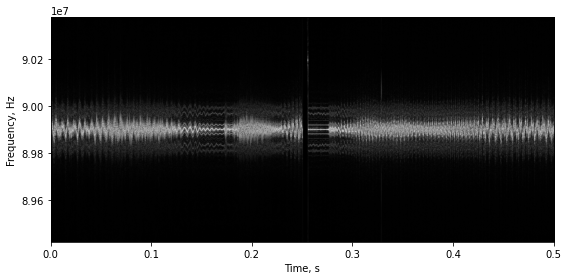

In [27]:
# Plot. Plotting may take a while!
#I'm not in the States so not sure what fc im supposed to choose so I directly use the given data
data = np.load("kpfa_12bit.npy")
fig = myspectrogram_hann_ovlp(data[:480000], 1024, fs, fc);
len(data)

#### Downsampling:

The bandwidth of an FM station is 200KHz. Since we sampled at 960KHz, you may be seeing several stations in the spectrogram. KCRW, the station we are interested in is in the middle around 89.9MHz.  We will need to filter out and select the desired station from the rest of the signals within the spectrum. 

Task:
- Design an FIR filter low-pass filter. The filter should be of  length 128 and the cutoff frequency be 100KHz. This will select the frequencies between -100KHz to 100KHz. To design the filter, we will use the function `signal.firwin` (We will talk more about this filter design technique later in class -- but in essence the function creates a windowed sinc function with the appropriate bandwidth for the given length). 
Type `signal.firwin?` and execute to get help. 

    h = signal.firwin(128,100000.0,nyq=fs/2,window='hanning')

- Plot the double-sided magnitude frequency response (log scale using `plt.semilogy`) by computing a zero-padded FFT to length 1024 and using fftshift. Use KHz as the x-axis units. 




Text(0.5, 0, 'KHz')

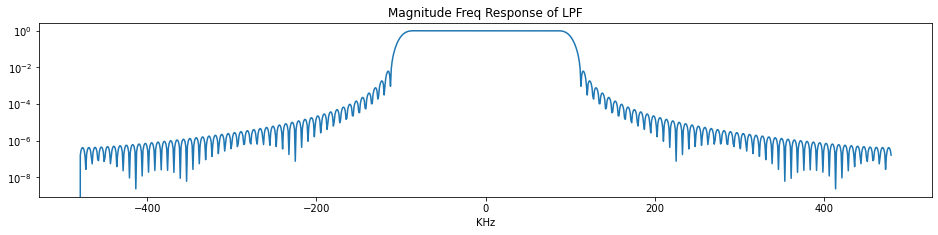

In [28]:
# Your code here
h = signal.firwin(128,100000.0,nyq=fs/2,window='hanning');
N=1024;
y= fft(h,N);
y = fftshift(y);
w, h = signal.freqz(y)
f = r_[-N/2:N/2]/N*fs
a, h = plt.figaspect(0.2)
fig = plt.figure(figsize=(a,h))
plt.semilogy(f/1e3,abs(y))
plt.title('Magnitude Freq Response of LPF')
plt.xlabel('KHz')

Now, filter the acquired SDR signal with the low-pass filter. Use the function `numpy.convolve`. Plot the spectrogram of the filtered signal. 

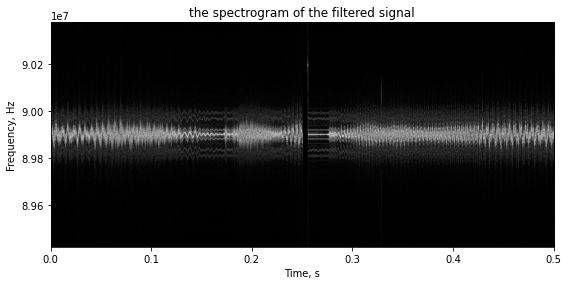

In [29]:
# Your code here
data = np.convolve(data,h)
fig = myspectrogram_hann_ovlp(data[:480000], 1024, fs, fc);
plt.title("the spectrogram of the filtered signal");

Our signal is now bandlimited with a bandwidth of 200KHz out of 960KHz. We can now downsample the signal to reduce computation without aliasing. 

- Decimate the signal by a factor of 4 by selecting every 4th sample, to get a signal representing a rate of 240KHz. After that, you have successfully implemented a downsampler through low-pass filtering and decimation! 

- Plot the spectrogram with a window size of 512. Remember to use the new sampling factor `fs/4.0` for the spectrogram.
- Do you see the rolloff of the low-pass fiter? Is there aliasing?


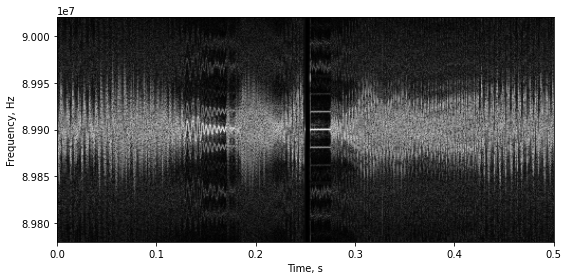

In [30]:
# Your code here
data_dec = data[0::4]
fig = myspectrogram_hann_ovlp(data_dec[:120000], 512, fs/4, fc);
#we can now see the rolloff of the LPF

At this point you have gone through this processing with half a second of data.  We will now acquire a longer segment, which will allow you to appreciate the audio that comes out once we demodulate it 

- Acquire 960000*8 samples, which is 8 seconds of data
- Filter and decimate (hence downsample) to the rate of 240KHz
- Plot the spectrogram **of the 1st second** i.e., of the first 240000 samples. 


In [32]:
fs = 960000
fc = 89.9e6
sdr = RtlSdr()
sdr.sample_rate = fs    # sampling rate
sdr.center_freq = fc   # center frequency
sdr.set_agc_mode(1)
sdr.set_manual_gain_enabled(0)
N_Samples = 960000*8
data = sdr.read_samples(N_Samples)   # get samples
sdr.close()

If you are having a hard time getting a good signal, you may use the 6 seconds of strong signal that had been originally collected by the UC Berkeley EE123 course staff from KPFA 94.1MHz station in the Bay Area. But if you have RTL-SDR, please submit with your own data collection.

One important difference between this data and the data you will collect is the SDR used has a 12-bit ADC and higher sampling rate (downsampled to match what you receive from the RTL-SDR), compared to 8-bits on your RTL-SDR. This means the ADC can represent up to 24 dB more dynamic range, and the process of downsampling can increase this value further. The limited dynamic range of your SDR means that the strong KCRW main broadcast can swamp the narrow and low power subcarrier signals. Having a larger dynamic range means that the subcarriers are better represented in the provided recording and should be clearer when you listen to them.

In [33]:
# Data collected with a 12-bit ADC from KPFA FM station
data = np.load("kpfa_12bit.npy")

Text(0.5, 1.0, 'the 1st second of the signal after filtering')

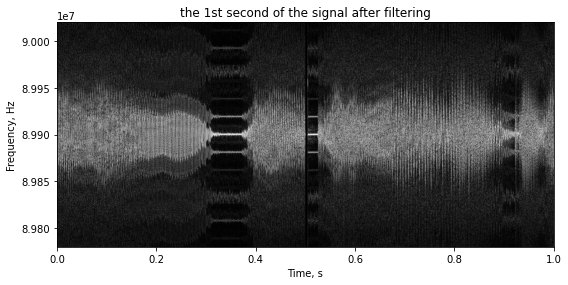

In [34]:
# Your code here
#changing to the 1st second instead of the first 0.5 sec
fig = myspectrogram_hann_ovlp(data_dec[:240000], 512, fs/4.0, fc);
plt.title("the 1st second of the signal after filtering")

#### FM Demodulation:

The plot does not resemble the broadcast FM spectrum figure above, since it is not yet FM demodulated. We can easily see that the signal is frequency modulated -- because its frequency looks like the time-signal of  speech or music.

The next step we are going to perform is to demodulate the FM signal and look at its spectrogram. For this we need to find the instantaneous frequency as a function of time, which is the time derivative of the phase. Computing the phase and then taking the derivative will be sensitive to phase wraps, which we would like to avoid. 


Instead, we will take the digital implementation version of the classical FM demodulatation using a limiter, followed by a discriminator. The limiter makes the input have constant amplitude, and the discriminator converts frequency deviations into amplitude modulation. Just as a comment, implementation of an accurate analog disciminator is very difficult whereas implementing a digital one is ridiculously easy!

##### Limiter
Recall that $y_b(t) = A(t)e^{ j2\pi (f_c-f_d) t + j2\pi \Delta f \int_0^t x(\tau) d\tau }.$ The leading coefficient $A(t)$ is some unwanted amplitude modulation, which can be a result of signal fading or other sources of signal variations. The role of the limiter component in an FM radio is to remove this amplitude modulation so the discriminator will only be sensitive to frequency variations. 

In the digital domain, implementing a limiter is done by simply dividing our signal by its amplitude. 

- Apply a limiter to your signal. To avoid dividing by 0, divide your signal by its amplitude plus epsilon, where epsilon = 1e-6 is adequate. 




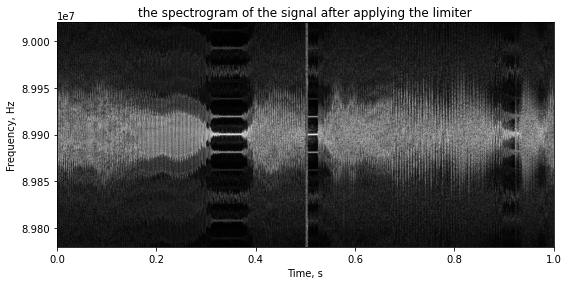

In [35]:
# Your code here
epsilon = 1e-6; 
data_lim = data_dec/(abs(data_dec)+epsilon); #dividing the signal by its amplitude
fig = myspectrogram_hann_ovlp(data_lim[:240000], 512, fs/4.0, fc);
plt.title("the spectrogram of the signal after applying the limiter");

##### Discriminator
Assuming that $f_c=f_d$, after the limiter our signal is $ y_b(t)=e^{ j2\pi \Delta f \int_0^t x(\tau) d\tau }.$ To get $x(t)$ we can compute:

$$\left(\frac{d}{dt}y_b(t)\right)y_b^*(t) = j2\pi\Delta f \cdot x(t)\cdot e^{ j2\pi \Delta f \int_0^t x(\tau) d\tau }\cdot e^{  -j2\pi \Delta f \int_0^t x(\tau) d\tau } = j2\pi\Delta f \cdot x(t)$$

Which gives us our desired signal when we take the imaginary part of the result. 


We will need to design a differentiator filter whose frequency response approximates the ideal frequency response, $H_{diff}(e^{j\omega}) = \omega$, of a differentiator. Since we are only going to demodulate up to 105KHz, we can allow the differentiator roll off to zero after that. 

- Design an FIR differentiator filter with length 31 using the function `signal.remez` which implements an equi-ripple min-max optimal filter design technique. It requires prescribing frequency bands and their corresponding frequency responses. We need to tell the function that it's a differentiator so it knows to match a linear frequency response within the band of interest. We will prescribe a linear frequency extending from 0-110KHz and then tapering to zero at the Nyquist frequency 120KHz. As we will learn later in class, since the filter is of even order (odd number of coefficients) and is antisymmetric, its Nyquist frequency must be zero!

Type `signal.remez?` for more information.

Specifically: 

    h_diff = signal.remez(31,[0.0,105000.0,120000.0,120000.0],[1.05/1.2,0],Hz = 240000.0, type='differentiator')
    
will try to get a linear frequency response from 0-105000 and zero amplitude at 120000.

- Plot the filter and its two sided magnitude frequency response (linear scale, compute a zero-padded FFT to length 1024 and use fftshift).




Text(0.5, 1.0, 'magnitude frequency response of h_diff')

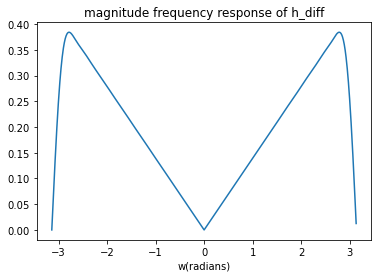

In [36]:
# Your code here
#signal.remez?
#ie.signal.remez(numtaps,bands,desired,weight=None,Hz=None,type='bandpass',maxiter=25,grid_density=16,fs=None,)
h_diff = signal.remez(31,[0.0,105000.0,120000.0,120000.0],[1.05/1.2,0],Hz = 240000.0, type='differentiator')
N=1024;
y= fft(h_diff,N);
y = fftshift(y);
w = np.r_[-1*np.pi : np.pi: 2*np.pi/N]
plt.plot(w,abs(y));
plt.xlabel("w(radians)")
plt.title("magnitude frequency response of h_diff")

Demodulate the FM signal by:
- Filtering the signal with the differentiator 
- Multiplying the result with the conjugate of the original signal
- Taking the imaginary component

Note, that the default implementation of `np.convolve` will have a delay of 16 samples with respect to the original signal. **To avoid that, use the option `mode='same'`.**

Note that after FM demodulation the signal should be real (by taking only the imaginary component) and hence only half the spectrum should be displayed. 

- Plot the spectrogram of the frequency demodulated signal

Text(0.5, 1.0, 'the spectrogram of the frequency demodulated signal')

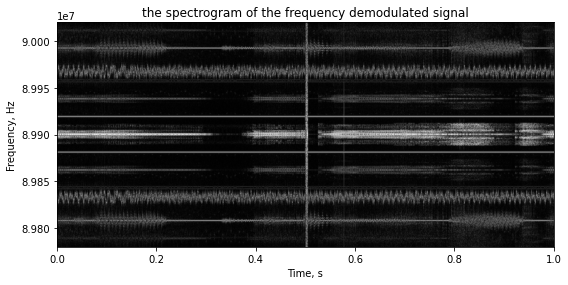

In [37]:
# Your code here
data_conj = np.conj(data_lim)
data_diff =np.convolve(data_lim,h_diff,mode='same') #Filtering the signal with the differentiator
#Multiplying the result with the conjugate of the original signal
# &Taking the imaginary component
data_demodulated = np.imag(data_diff*data_conj);
fig = myspectrogram_hann_ovlp(data_demodulated[:240000], 512, fs/4.0, fc);
plt.title("the spectrogram of the frequency demodulated signal")

#### Play the mono  (Left  + Right Channel)


The mono signal covers the frequency range of 30Hz-16KHz. However, there are many other signals present. There's another problem. Our sampled signal is at a rate of 240KHz. The soundcard on most modern computers can only deal with a sampling rate of 48KHz. Similarly to the downsampling operation we did before, filter our signal and decimate it before being able to play it. 

- Design a 129 length FIR  Bandpass filter with a cuttoff frequency of 16KHz using the command:

    h = signal.firwin(129,16000.0,nyq=240000.0/2, window='hanning')

- Filter the signal and decimate by a factor of 5 to reduce the rate to 48KHz. Store the result in the a variable called `LPR` (Left + Right). Display the spectrogram of the `LPR`. Use a window length of 256. 





Text(0.5, 1.0, 'spectrogram of the LPR')

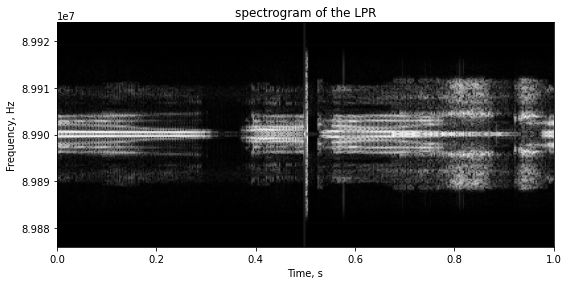

In [38]:
# Your code here
h_bp = signal.firwin(129,16000.0,nyq=240000.0/2, window='hanning') #129 length FIR Bandpass filter
data_final = np.convolve(h_bp,data_demodulated) #filter the signal
LPR = data_final[0::5] #decimate by a factor of 5
myspectrogram_hann_ovlp(LPR[:48000], 256, fs/20.0, fc);
plt.title("spectrogram of the LPR")

#### Playing the Mono (Left + Right channel)

- Normalize `LPR` so it is in the range between -1 and 1. 
- Play it. 

Do you hear radio?



In [22]:
# Your code below:

LPR = LPR/max(abs(LPR)+epsilon) #normalize LPR between (-1,1)
sd.play(LPR,48000,blocking=True)


In [24]:
# Write to wav file
write('fm_LR.wav', 48000, LPR)

In order to listen to the radio continuously, you would have to implement a stream processing using double buffer. The SDR would fill one buffer while your code demodulates the other one. Of course, you would need to process the data faster than the samples come in. Finally, you would also have to implement an overlap and save/add approach for streaming convolutions so that the sound will not have interruptions or artifacts at the edges of the buffers. 